In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.4 MB/s eta 0:00:00


In [86]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm
import torch
from torch_geometric.data import Data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from torch_geometric.utils import from_networkx


In [87]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency

import sys
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import chi2,f_classif, mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import RobustScaler
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.naive_bayes import ComplementNB, GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import classification_report, confusion_matrix


In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
df = pd.read_csv('/content/drive/MyDrive/Nhóm 3/Bài tập trên lớp/Báo cáo tiến trình/Project/feature_extraction.csv')

# Sau khi combine

In [90]:
def build_initial_graph(W, feature_names):
    G = nx.Graph()
    num_features = len(feature_names)
    for i, name in enumerate(feature_names):
        G.add_node(i, label=name)
    for i in range(num_features):
        for j in range(i + 1, num_features):
            if W[i, j] > 0:
                G.add_edge(i, j, weight=W[i, j])
    return G


def average_pooling_layer(data, clusters):
    pooled_data = pd.DataFrame()
    for i, cluster in enumerate(clusters):
        cluster_data = data.iloc[:, cluster]
        pooled_data[f"Cluster_{i+1}"] = cluster_data.mean(axis=1)
    return pooled_data


def cluster_graph(G, num_clusters):
    adj_matrix = nx.to_numpy_array(G)

    clustering = AgglomerativeClustering(
        n_clusters=num_clusters, metric='precomputed', linkage='average'
    )
    cluster_labels = clustering.fit_predict(1 - adj_matrix)
    clusters = [[] for _ in range(num_clusters)]
    for node, label in enumerate(cluster_labels):
        clusters[label].append(node)
    return clusters


def hierarchical_clustering_with_pooling(data, W, feature_names, num_layers, num_clusters):
    pooled_layers = [data]
    graphs = []

    G = build_initial_graph(W, feature_names)
    graphs.append(G)

    for layer in range(num_layers):
        print(f"Building Layer {layer + 1}...")
        clusters = cluster_graph(G, num_clusters)
        pooled_data = average_pooling_layer(pooled_layers[-1], clusters)
        pooled_layers.append(pooled_data)
        G = build_initial_graph(
            np.corrcoef(pooled_data.T, rowvar=True), pooled_data.columns
        )
        graphs.append(G)

    return pooled_layers, graphs


def visualize_graph(G, title="Feature Network"):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'),
        node_size=700, font_size=10, font_color='white', font_weight='bold'
    )
    edge_colors = [d['weight'] for _, _, d in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.viridis, width=2)
    plt.title(title)
    plt.show()

In [91]:
df = df[['dtbhk_truoc', 'drltl', 'sotchk', 'namhoc', 'xeploai']]
feature_names = df.columns.drop('xeploai').tolist()

In [92]:
scaler = StandardScaler()
standardized_features = pd.DataFrame(
        scaler.fit_transform(df[feature_names]), columns=feature_names
    )

In [93]:
correlation_matrix = np.corrcoef(standardized_features.T)
np.fill_diagonal(correlation_matrix, 0)   #loại bỏ giá trị tương quan với chính nó
num_layers = 3
num_clusters = 3
pooled_layers, graphs = hierarchical_clustering_with_pooling(
  standardized_features, correlation_matrix, feature_names, num_layers, num_clusters
)

Building Layer 1...
Building Layer 2...
Building Layer 3...


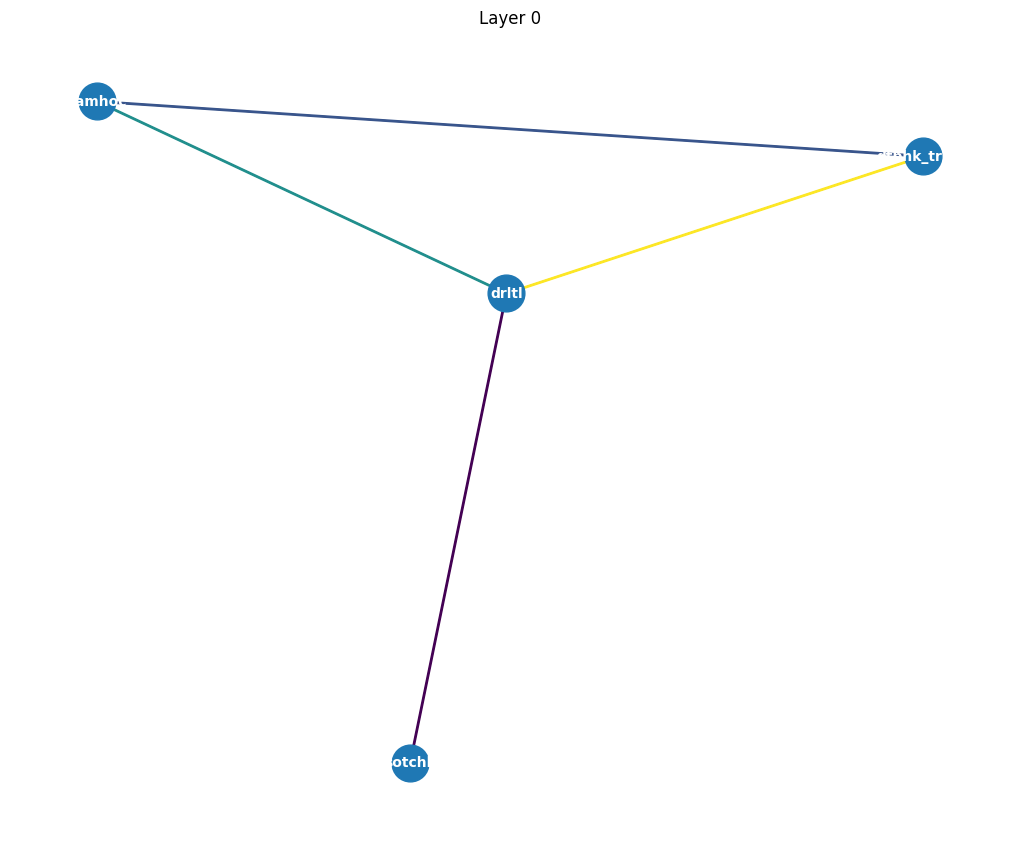

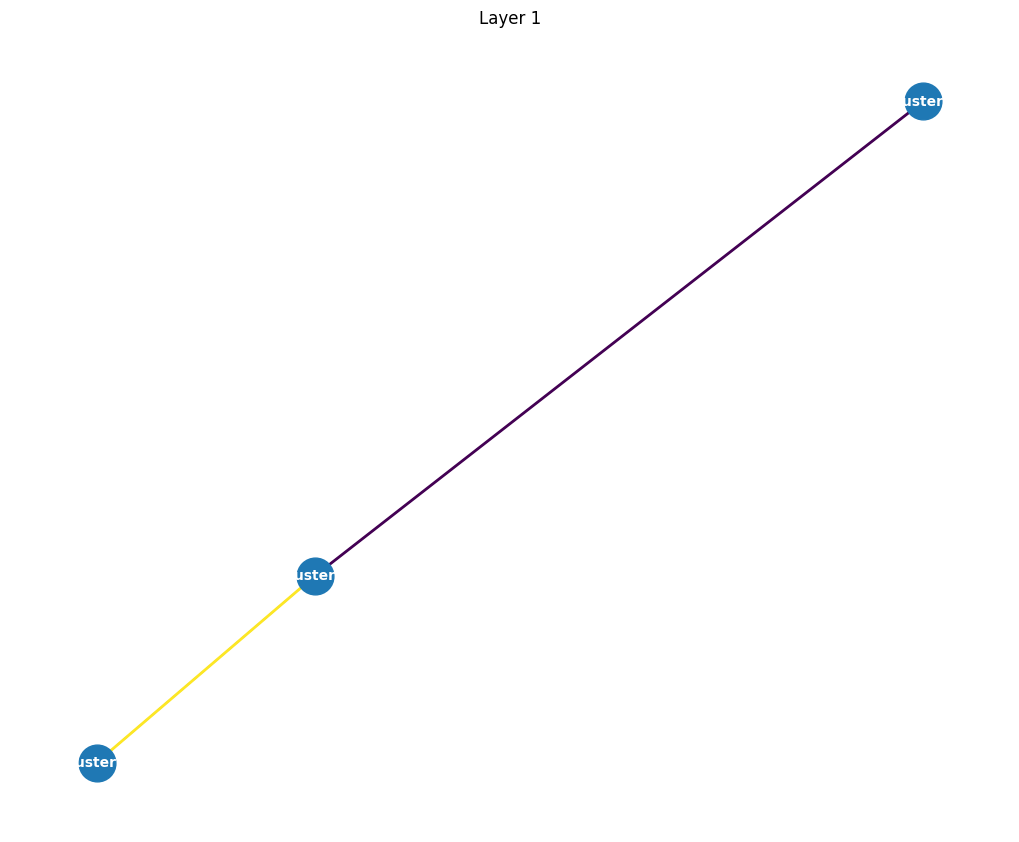

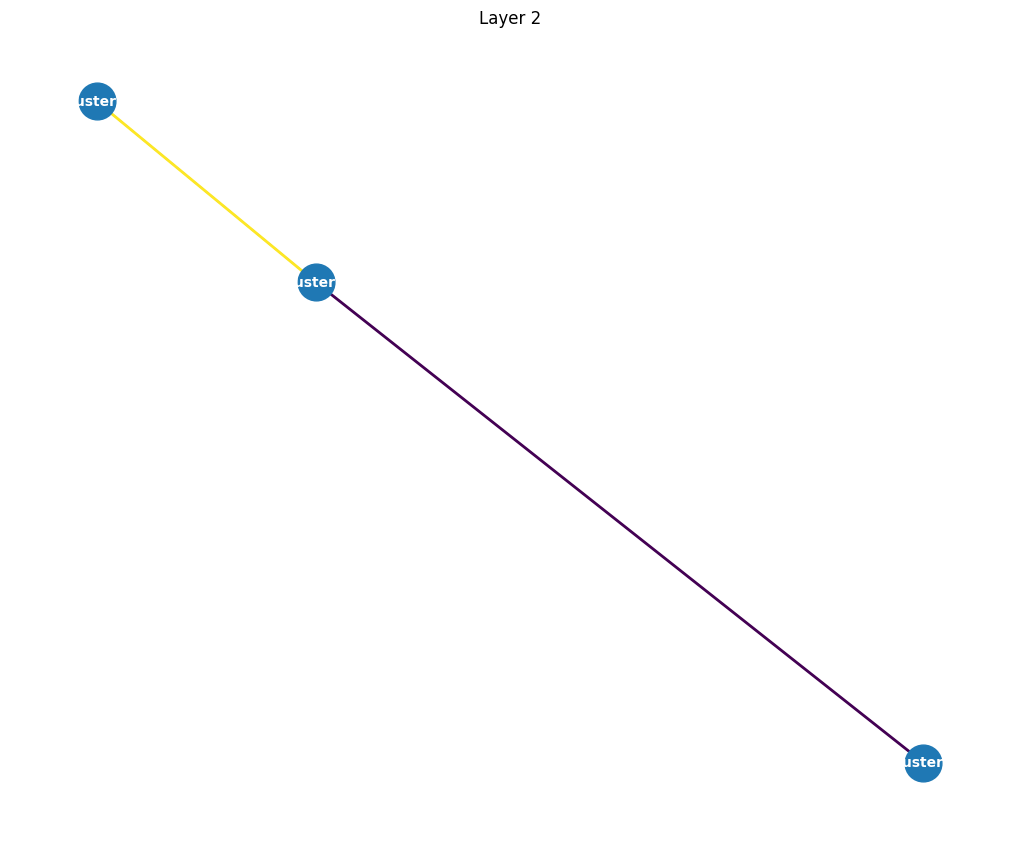

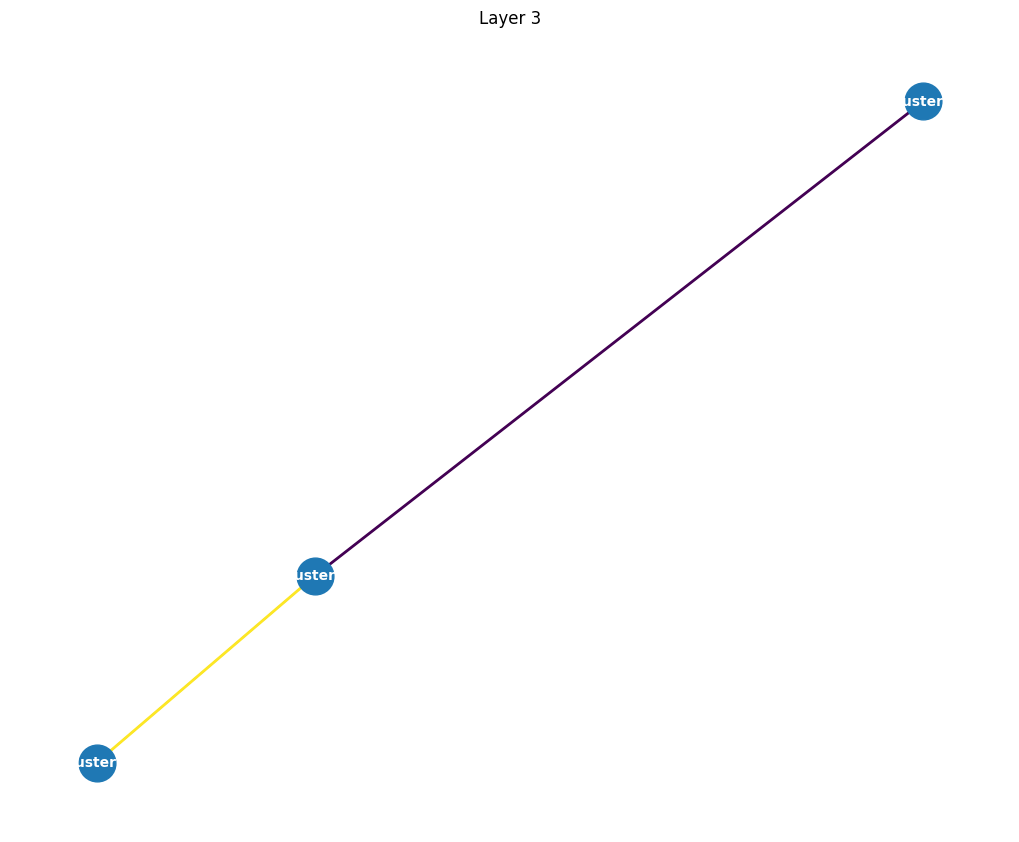

In [94]:
#Visualize
for i, G in enumerate(graphs):
        visualize_graph(G, title=f"Layer {i}")

In [95]:
#Dữ liếu sau pooling
for i, pooled_data in enumerate(pooled_layers):
  print(f"Pooled Data for Layer {i}:")
  print(pooled_data.head())

Pooled Data for Layer 0:
   dtbhk_truoc     drltl    sotchk    namhoc
0     1.065896  0.998521  0.747090  0.181935
1     1.157895  0.998521 -0.563109  0.609536
2     1.221144  0.998521  0.310357  0.609536
3     1.014147  0.998521  0.528724  1.037136
4     0.893398  0.998521  0.528724  1.037136
Pooled Data for Layer 1:
   Cluster_1  Cluster_2  Cluster_3
0   1.032209   0.747090   0.181935
1   1.078208  -0.563109   0.609536
2   1.109833   0.310357   0.609536
3   1.006334   0.528724   1.037136
4   0.945960   0.528724   1.037136
Pooled Data for Layer 2:
   Cluster_1  Cluster_2  Cluster_3
0   0.181935   0.747090   1.032209
1   0.609536  -0.563109   1.078208
2   0.609536   0.310357   1.109833
3   1.037136   0.528724   1.006334
4   1.037136   0.528724   0.945960
Pooled Data for Layer 3:
   Cluster_1  Cluster_2  Cluster_3
0   1.032209   0.747090   0.181935
1   1.078208  -0.563109   0.609536
2   1.109833   0.310357   0.609536
3   1.006334   0.528724   1.037136
4   0.945960   0.528724   1.037136


In [96]:
X_pooled = pooled_layers[-1]  #lấy layer cuối
y = df['xeploai']

In [97]:
print("Original X shape:", X_pooled.shape)
print("Original y shape:", y.shape)

Original X shape: (35849, 3)
Original y shape: (35849,)


In [98]:
resampler = SMOTEENN(sampling_strategy="auto", random_state=42)
X, y = resampler.fit_resample(X_pooled, y)

In [99]:
print("Sampling X shape:", X.shape)
print("Sampling y shape:", y.shape)

Sampling X shape: (24496, 3)
Sampling y shape: (24496,)


In [100]:
print(X.dtypes)  # Kiểm tra kiểu dữ liệu của từng cột
print(X.head())  # Hiển thị 5 dòng đầu tiên để kiểm tra


Cluster_1    float64
Cluster_2    float64
Cluster_3    float64
dtype: object
   Cluster_1  Cluster_2  Cluster_3
0  -1.987185   1.183824  -1.956068
1  -0.749342   0.091991  -0.245665
2  -1.715332  -2.091675   0.181935
3  -0.874234   0.747090   0.609536
4  -1.637707   1.402190   1.464737


In [101]:
X = X.to_numpy()  # Chuyển DataFrame thành NumPy array
y = y.to_numpy()


In [102]:
# Tạo đối tượng Graph
node_features = torch.tensor(X, dtype=torch.float)  # Đặc trưng các nút
labels = torch.tensor(y, dtype=torch.long)          # Nhãn của các nút
edge_index = torch.tensor(np.array(graphs[-1].edges).T, dtype=torch.long)  # Danh sách cạnh từ đồ thị cuối

# Tạo đối tượng đồ thị PyTorch Geometric
data = Data(x=node_features, edge_index=edge_index, y=labels)

In [103]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu
train_idx, test_idx = train_test_split(range(len(labels)), test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)

# Tạo mask
train_mask = torch.zeros(len(labels), dtype=torch.bool)
train_mask[train_idx] = True

val_mask = torch.zeros(len(labels), dtype=torch.bool)
val_mask[val_idx] = True

test_mask = torch.zeros(len(labels), dtype=torch.bool)
test_mask[test_idx] = True

# Thêm mask vào đồ thị
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask


In [104]:

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [105]:
input_dim = data.x.shape[1]
hidden_dim = 16
output_dim = len(labels.unique())

model = GCN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


In [106]:
def train(data, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


In [107]:
@torch.no_grad()
def evaluate(data, model, mask):
    model.eval()
    out = model(data)
    pred = out[mask].argmax(dim=1)  # Lấy nhãn dự đoán
    acc = (pred == data.y[mask]).sum().item() / mask.sum().item()
    return acc


Trực quan hóa trước khi train

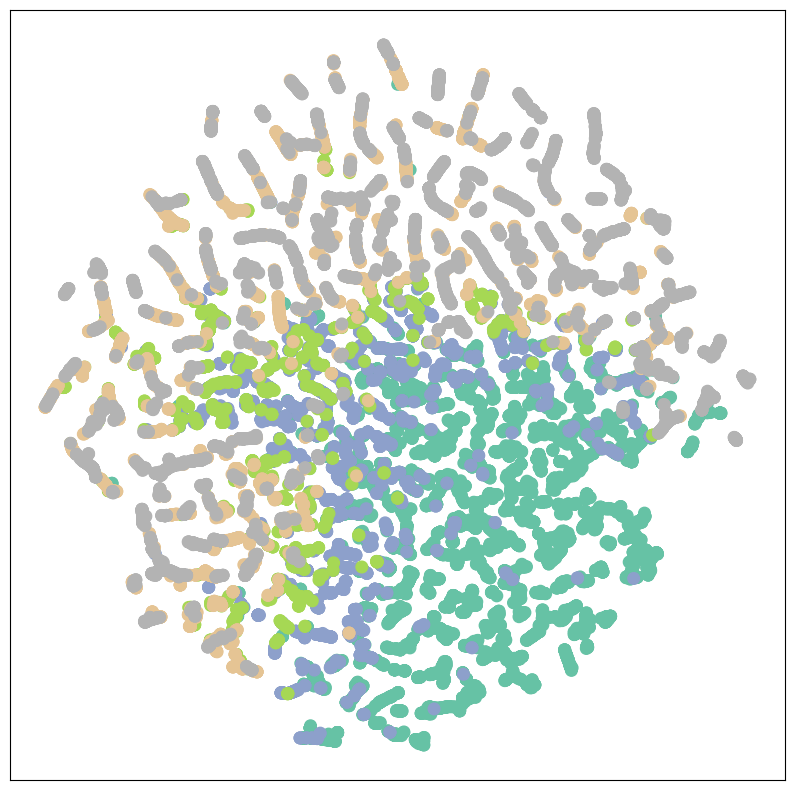

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

model.eval()
out = model(data)
visualize(out, color=data.y)

In [121]:
num_epochs = 200
train_accuracies = []
val_accuracies = []
for epoch in range(num_epochs):
    loss = train(data, model, optimizer, criterion)
    train_acc = evaluate(data, model, data.train_mask)
    val_acc = evaluate(data, model, data.val_mask)
    # Lưu trữ độ chính xác của mỗi epoch
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1, Loss: 0.5694, Train Acc: 0.7651, Val Acc: 0.7731
Epoch 2, Loss: 0.5692, Train Acc: 0.7651, Val Acc: 0.7735
Epoch 3, Loss: 0.5689, Train Acc: 0.7651, Val Acc: 0.7751
Epoch 4, Loss: 0.5687, Train Acc: 0.7657, Val Acc: 0.7751
Epoch 5, Loss: 0.5684, Train Acc: 0.7660, Val Acc: 0.7747
Epoch 6, Loss: 0.5681, Train Acc: 0.7657, Val Acc: 0.7747
Epoch 7, Loss: 0.5679, Train Acc: 0.7656, Val Acc: 0.7751
Epoch 8, Loss: 0.5676, Train Acc: 0.7657, Val Acc: 0.7747
Epoch 9, Loss: 0.5674, Train Acc: 0.7658, Val Acc: 0.7751
Epoch 10, Loss: 0.5671, Train Acc: 0.7657, Val Acc: 0.7747
Epoch 11, Loss: 0.5669, Train Acc: 0.7657, Val Acc: 0.7743
Epoch 12, Loss: 0.5667, Train Acc: 0.7655, Val Acc: 0.7739
Epoch 13, Loss: 0.5665, Train Acc: 0.7657, Val Acc: 0.7743
Epoch 14, Loss: 0.5663, Train Acc: 0.7661, Val Acc: 0.7743
Epoch 15, Loss: 0.5661, Train Acc: 0.7666, Val Acc: 0.7755
Epoch 16, Loss: 0.5659, Train Acc: 0.7669, Val Acc: 0.7759
Epoch 17, Loss: 0.5657, Train Acc: 0.7671, Val Acc: 0.7780
Epoch 

In [110]:
test_acc = evaluate(data, model, data.test_mask)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.7722


In [122]:
# Tính độ lệch chuẩn của độ chính xác
train_acc_std = np.std(train_accuracies)
val_acc_std = np.std(val_accuracies)

In [123]:
print(f"Train Accuracy Standard Deviation: {train_acc_std:.4f}")
print(f"Validation Accuracy Standard Deviation: {val_acc_std:.4f}")

Train Accuracy Standard Deviation: 0.0040
Validation Accuracy Standard Deviation: 0.0031


Trực quan hóa sau khi train

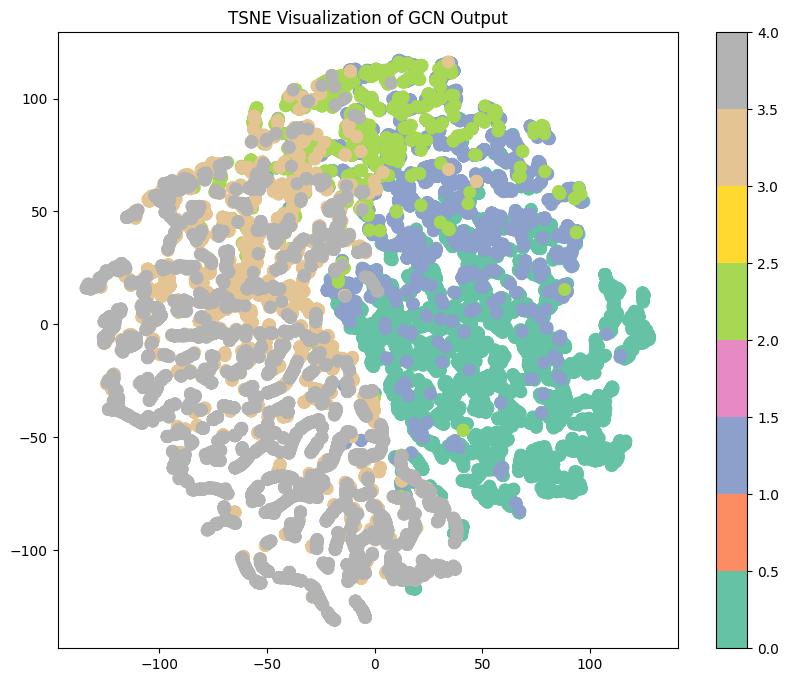

In [111]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_tsne(data, model):
    model.eval()
    out = model(data)
    z = TSNE(n_components=2).fit_transform(out.numpy())
    plt.figure(figsize=(10, 8))
    plt.scatter(z[:, 0], z[:, 1], c=data.y.numpy(), cmap="Set2", s=70)
    plt.title("TSNE Visualization of GCN Output")
    plt.colorbar()
    plt.show()

plot_tsne(data, model)


In [114]:
unique_classes = np.unique(data.y.numpy())
y_pred = model(data).argmax(dim=1).numpy()
y_test = data.y.numpy()
report = classification_report(y_test, y_pred, target_names=[f"Class {cls}" for cls in unique_classes])
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.88      0.91      0.90      8406
     Class 1       0.65      0.68      0.67      3735
     Class 2       0.56      0.32      0.41      1701
     Class 3       0.59      0.47      0.52      3436
     Class 4       0.78      0.89      0.83      7218

    accuracy                           0.77     24496
   macro avg       0.69      0.65      0.67     24496
weighted avg       0.75      0.77      0.76     24496



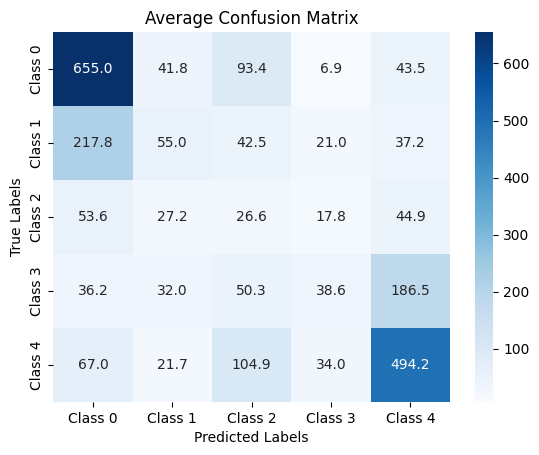

In [124]:
sns.heatmap(average_conf_matrix, annot=True, fmt='.1f', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Average Confusion Matrix')
plt.show()

# Trước khi combine

In [125]:
# Chọn cột làm features

df = df[['dtbhk_truoc', 'drltl', 'sotchk', 'namhoc', 'xeploai']]
feature_columns = ['namhoc', 'drltl', 'sotchk', 'dtbhk_truoc']
features = df[feature_columns]


# Chuẩn hóa features

scaler = StandardScaler()

node_features = scaler.fit_transform(features)

In [126]:
#Tạo danh sách liên kết dựa trên KNN: nối các nodes gần nhau nhất về mặt khoảng cách euclide
# Tạo ma trận adjacency bằng KNN
adjacency_matrix = kneighbors_graph(node_features, n_neighbors=5, mode='connectivity')
edges = adjacency_matrix.nonzero()
edge_list = list(zip(edges[0], edges[1]))

edge_list

[(0, 9708),
 (0, 10484),
 (0, 12032),
 (0, 4405),
 (0, 6738),
 (1, 22645),
 (1, 8787),
 (1, 14006),
 (1, 29238),
 (1, 20185),
 (2, 30035),
 (2, 14521),
 (2, 8685),
 (2, 293),
 (2, 17110),
 (3, 6268),
 (3, 6673),
 (3, 26407),
 (3, 410),
 (3, 8285),
 (4, 31906),
 (4, 6721),
 (4, 23182),
 (4, 15663),
 (4, 3494),
 (5, 30763),
 (5, 6579),
 (5, 23994),
 (5, 16890),
 (5, 10348),
 (6, 13591),
 (6, 30888),
 (6, 7915),
 (6, 7252),
 (6, 13798),
 (7, 9597),
 (7, 21080),
 (7, 8430),
 (7, 7082),
 (7, 34298),
 (8, 33488),
 (8, 25282),
 (8, 24776),
 (8, 5562),
 (8, 29760),
 (9, 18366),
 (9, 17487),
 (9, 7431),
 (9, 13569),
 (9, 5184),
 (10, 11567),
 (10, 31656),
 (10, 34353),
 (10, 4064),
 (10, 24957),
 (11, 34119),
 (11, 30573),
 (11, 6472),
 (11, 14452),
 (11, 33761),
 (12, 614),
 (12, 3133),
 (12, 25900),
 (12, 32802),
 (12, 23051),
 (13, 6036),
 (13, 14757),
 (13, 26455),
 (13, 12209),
 (13, 2373),
 (14, 22203),
 (14, 26575),
 (14, 3611),
 (14, 32657),
 (14, 5636),
 (15, 25520),
 (15, 9056),
 (15,

In [127]:

# Chuyển đổi sang tensor
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

# Tạo đối tượng Graph
data = Data(x=x, edge_index=edge_index)



In [128]:
labels = torch.tensor(df['xeploai'].values, dtype=torch.long)

# Chia các chỉ số nút thành tập train, val, test
train_idx, test_idx = train_test_split(range(len(labels)), test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)

# Tạo mask cho các tập
train_mask = torch.zeros(len(labels), dtype=torch.bool)
train_mask[train_idx] = True
val_mask = torch.zeros(len(labels), dtype=torch.bool)
val_mask[val_idx] = True
test_mask = torch.zeros(len(labels), dtype=torch.bool)
test_mask[test_idx] = True

# Thêm vào graph object
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask
data.y = labels

In [129]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x



In [130]:
model = GCN(in_channels=data.x.shape[1], hidden_channels=16, out_channels=len(labels.unique()))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

In [131]:
print(model)

GCN(
  (conv1): GCNConv(4, 16)
  (conv2): GCNConv(16, 5)
)


Trực quan hóa trước khi train

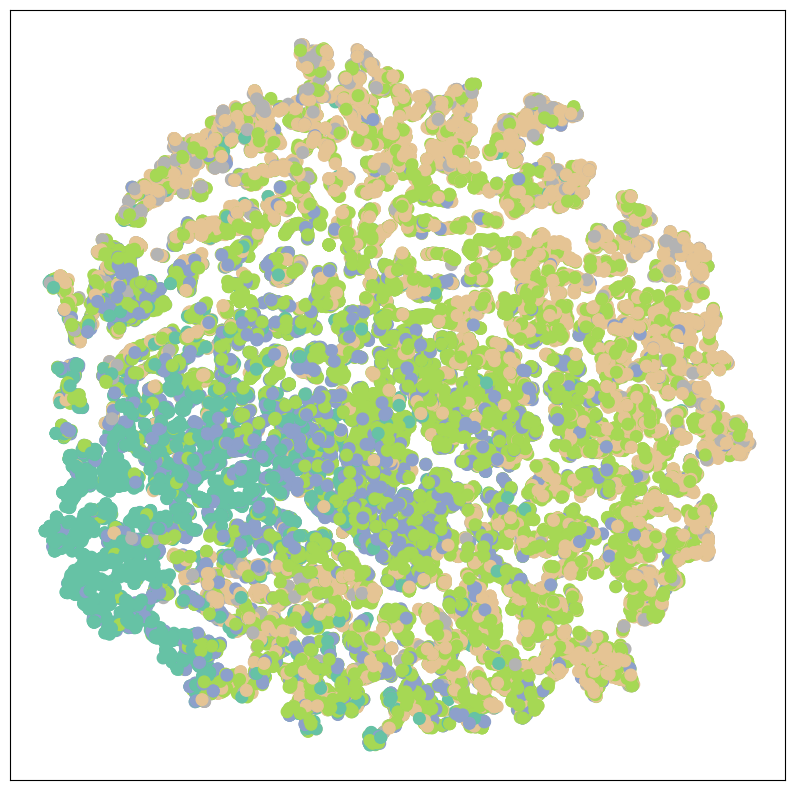

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

model.eval()
out = model(data)
visualize(out, color=data.y)


In [133]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Loss trên tập train
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    return loss.item()


In [134]:
@torch.no_grad()
def evaluate(mask):
    model.eval()
    out = model(data)
    pred = out[mask].argmax(dim=1)  # Lấy dự đoán
    acc = (pred == data.y[mask]).sum().item() / mask.sum().item()
    return acc


In [135]:
num_epochs = 200
train_accuracies = []
val_accuracies = []
for epoch in range(num_epochs):
    loss = train(data, model, optimizer, criterion)
    train_acc = evaluate(data, model, data.train_mask)
    val_acc = evaluate(data, model, data.val_mask)
    # Lưu trữ độ chính xác của mỗi epoch
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1, Loss: 1.8546, Train Acc: 0.0891, Val Acc: 0.0848
Epoch 2, Loss: 1.7839, Train Acc: 0.1726, Val Acc: 0.1707
Epoch 3, Loss: 1.7185, Train Acc: 0.2407, Val Acc: 0.2477
Epoch 4, Loss: 1.6583, Train Acc: 0.2886, Val Acc: 0.3010
Epoch 5, Loss: 1.6032, Train Acc: 0.3275, Val Acc: 0.3314
Epoch 6, Loss: 1.5530, Train Acc: 0.3534, Val Acc: 0.3545
Epoch 7, Loss: 1.5074, Train Acc: 0.3874, Val Acc: 0.3880
Epoch 8, Loss: 1.4663, Train Acc: 0.4216, Val Acc: 0.4201
Epoch 9, Loss: 1.4295, Train Acc: 0.4458, Val Acc: 0.4421
Epoch 10, Loss: 1.3968, Train Acc: 0.4576, Val Acc: 0.4519
Epoch 11, Loss: 1.3678, Train Acc: 0.4658, Val Acc: 0.4594
Epoch 12, Loss: 1.3420, Train Acc: 0.4730, Val Acc: 0.4616
Epoch 13, Loss: 1.3191, Train Acc: 0.4762, Val Acc: 0.4628
Epoch 14, Loss: 1.2985, Train Acc: 0.4778, Val Acc: 0.4669
Epoch 15, Loss: 1.2800, Train Acc: 0.4784, Val Acc: 0.4669
Epoch 16, Loss: 1.2631, Train Acc: 0.4789, Val Acc: 0.4672
Epoch 17, Loss: 1.2476, Train Acc: 0.4798, Val Acc: 0.4692
Epoch 

In [136]:
test_acc = evaluate(data.test_mask)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.5835


In [137]:
# Tính độ lệch chuẩn của độ chính xác
train_acc_std = np.std(train_accuracies)
val_acc_std = np.std(val_accuracies)

print(f"Train Accuracy Standard Deviation: {train_acc_std:.4f}")
print(f"Validation Accuracy Standard Deviation: {val_acc_std:.4f}")

Train Accuracy Standard Deviation: 0.0040
Validation Accuracy Standard Deviation: 0.0031


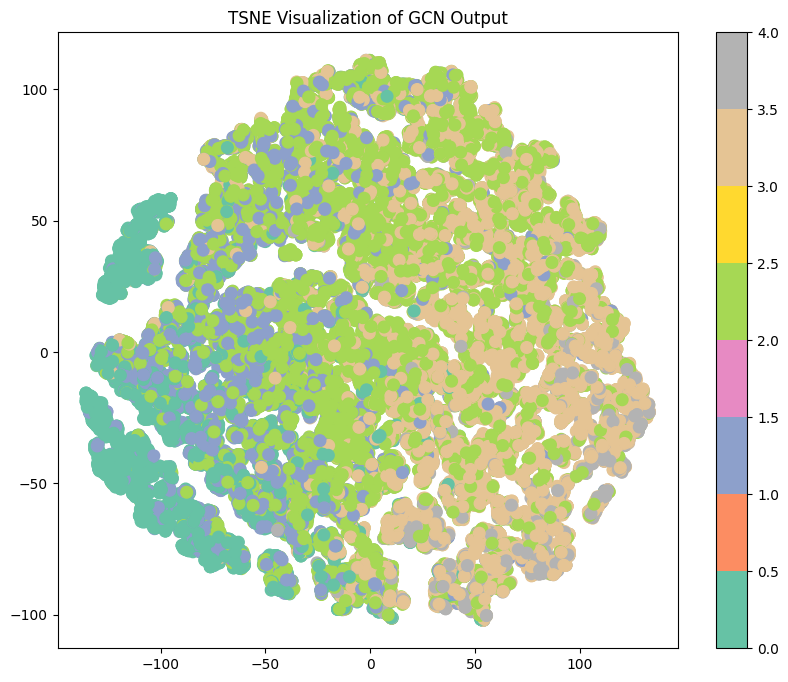

In [138]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_tsne(data, model):
    model.eval()
    out = model(data)
    z = TSNE(n_components=2).fit_transform(out.numpy())
    plt.figure(figsize=(10, 8))
    plt.scatter(z[:, 0], z[:, 1], c=data.y.numpy(), cmap="Set2", s=70)
    plt.title("TSNE Visualization of GCN Output")
    plt.colorbar()
    plt.show()

plot_tsne(data, model)


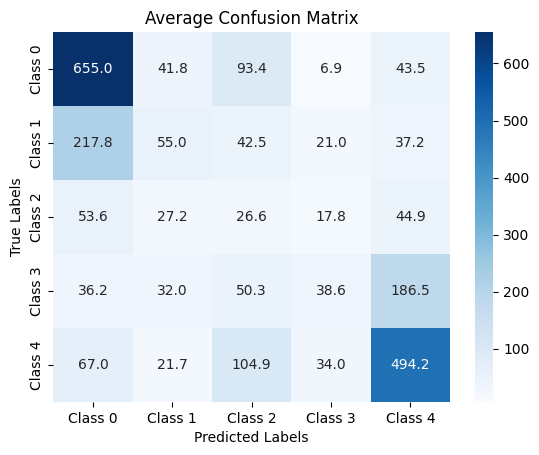

In [139]:
sns.heatmap(average_conf_matrix, annot=True, fmt='.1f', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Average Confusion Matrix')
plt.show()

In [140]:
unique_classes = np.unique(data.y.numpy())
y_pred = model(data).argmax(dim=1).numpy()
y_test = data.y.numpy()
report = classification_report(y_test, y_pred, target_names=[f"Class {cls}" for cls in unique_classes])
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.71      0.68      0.69      4711
     Class 1       0.45      0.15      0.23      5144
     Class 2       0.58      0.74      0.65     14539
     Class 3       0.59      0.66      0.62      9982
     Class 4       0.28      0.00      0.01      1473

    accuracy                           0.59     35849
   macro avg       0.52      0.45      0.44     35849
weighted avg       0.57      0.59      0.56     35849



In [141]:
@torch.no_grad()
def predict_single(data, index):
    model.eval()  # Đặt mô hình ở chế độ đánh giá
    out = model(data)  # Dự đoán toàn bộ tập dữ liệu
    pred = out.argmax(dim=1)  # Lấy nhãn dự đoán (class với giá trị xác suất cao nhất)

    # Lấy thông tin của dòng test
    feature_values = data.x[index].cpu().numpy()
    predicted_label = pred[index].item()
    true_label = data.y[index].item()

    return feature_values, predicted_label, true_label


In [142]:
# Lấy chỉ số của các dòng trong tập test
test_indices = torch.where(data.test_mask)[0]

# Chọn dòng test đầu tiên
test_index = test_indices[0].item()

# Thực hiện dự đoán
features, predicted_label, true_label = predict_single(data, test_index)

# In kết quả
print("Dòng dữ liệu test:")
print("Features:", features)
print(f"Dự đoán: {predicted_label}, Thực tế: {true_label}")


Dòng dữ liệu test:
Features: [ 0.18193512  0.99852127 -0.56310916  0.9508972 ]
Dự đoán: 3, Thực tế: 3
